# Hello, PyTorch! -- MNIST Handwritten Digits

- https://en.wikipedia.org/wiki/MNIST_database

# Load Datasets

In [1]:
import torch
from torchvision import datasets, transforms

In [7]:
x = datasets.MNIST('data', download=True)
x[0]

1.7%

Failed to download (trying next):
HTTP Error 403: Forbidden



100.0%


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



100.0%

Failed to download (trying next):
HTTP Error 403: Forbidden

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw




7.9%

Failed to download (trying next):
HTTP Error 403: Forbidden



100.0%


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100.0%

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



(<PIL.Image.Image image mode=L size=28x28>, 5)

In [8]:
transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
    ])

In [9]:
dataset1 = datasets.MNIST('data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(dataset1, batch_size=64)

dataset2 = datasets.MNIST('data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(dataset2, batch_size=1000)

In [10]:
i, x = next(enumerate(train_loader))
x[0].shape

torch.Size([64, 1, 28, 28])

# View Image

In [11]:
import numpy as np
import scipy
import matplotlib.pyplot as plt

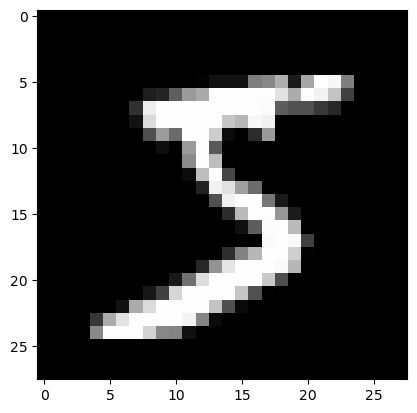

In [12]:
i, x = next(enumerate(train_loader))
x2 = np.squeeze(x[0][0])
plt.imshow(x2, cmap='gray')

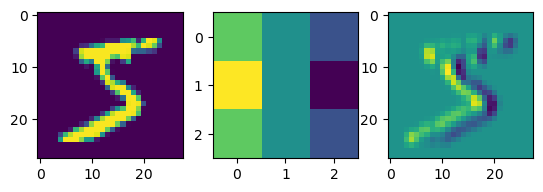

In [13]:
kernel = np.array([[1, 0, -1], [2, 0, -2], [1, 0, -1]])
y = scipy.ndimage.convolve(x2, kernel)

fig, axes = plt.subplots(1,3)
axes[0].imshow(x2)
axes[1].imshow(kernel)
axes[2].imshow(y)

# Create Network

In [14]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchinfo import summary

In [15]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

In [16]:
network = Net()
optimizer = optim.SGD(network.parameters(), lr=0.01, momentum=0.5)
summary(network, input_size=(1,28,28))

/opt/anaconda3/envs/pytorch/lib/python3.13/site-packages/torch/nn/functional.py:1545: UserWarning: dropout2d: Received a 3D input to dropout2d and assuming that channel-wise 1D dropout behavior is desired - input is interpreted as shape (N, C, L), where C is the channel dim. This behavior will change in a future release to interpret the input as one without a batch dimension, i.e. shape (C, H, W). To maintain the 1D channel-wise dropout behavior, please switch to using dropout1d instead.
  warnings.warn(
/var/folders/m9/f9b1skd55v35_qp4hcflk2qh0000gp/T/ipykernel_79719/161431047.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Layer (type:depth-idx)                   Output Shape              Param #
Net                                      [1, 10]                   --
├─Conv2d: 1-1                            [10, 24, 24]              260
├─Conv2d: 1-2                            [20, 8, 8]                5,020
├─Dropout2d: 1-3                         [20, 8, 8]                --
├─Linear: 1-4                            [1, 50]                   16,050
├─Linear: 1-5                            [1, 10]                   510
Total params: 21,840
Trainable params: 21,840
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.88
Input size (MB): 0.00
Forward/backward pass size (MB): 0.06
Params size (MB): 0.09
Estimated Total Size (MB): 0.15

# Visualize Weights

In [17]:
def visualize():
    i, x = next(enumerate(test_loader))
    x2 = np.squeeze(x[0][0])
    weights = network.conv1.weight.data
    
    fig, axes = plt.subplots(10,2)
    for i in range(10):
        weights_np = np.squeeze(weights.numpy()[i,0,:,:])
        axes[i,0].imshow(weights_np)
        axes[i,1].imshow(scipy.ndimage.convolve(x2, weights_np))

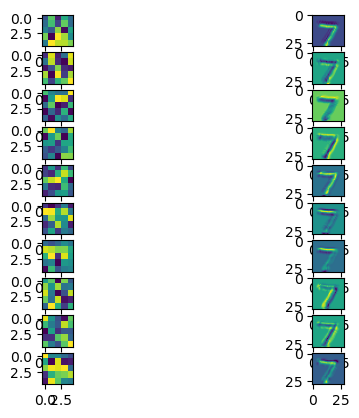

In [18]:
visualize()

# Predict Using Network

In [19]:
i, x = next(enumerate(train_loader))
x[1][:5]

tensor([5, 0, 4, 1, 9])

In [20]:
y = network(x[0])
pred = y.data.max(1)[1]
pred[:5]

/var/folders/m9/f9b1skd55v35_qp4hcflk2qh0000gp/T/ipykernel_79719/161431047.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


tensor([0, 6, 3, 6, 3])

# First Test and Train

In [21]:
def test():
  network.eval()
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = network(data)
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  print('Test accuracy: {:.0f}%\n'.format(100. * correct / len(test_loader.dataset)))

In [22]:
test()

/var/folders/m9/f9b1skd55v35_qp4hcflk2qh0000gp/T/ipykernel_79719/161431047.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Test accuracy: 8%



In [23]:
optimizer = optim.SGD(network.parameters(), lr=0.01, momentum=0.5)
def train():
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    output = network(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % 100 == 0:
      print('Train loss: {:.6f}'.format(loss.item()))

In [24]:
train()

/var/folders/m9/f9b1skd55v35_qp4hcflk2qh0000gp/T/ipykernel_79719/161431047.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train loss: 2.312609
Train loss: 1.782219
Train loss: 0.959346
Train loss: 0.748140
Train loss: 0.591459
Train loss: 0.544676
Train loss: 0.417284
Train loss: 0.509996
Train loss: 0.680721
Train loss: 0.636873


# Train Network

In [25]:
network = Net()
optimizer = optim.SGD(network.parameters(), lr=0.01, momentum=0.5)
for epoch in range(5):
    train()
    test()

/var/folders/m9/f9b1skd55v35_qp4hcflk2qh0000gp/T/ipykernel_79719/161431047.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train loss: 2.332934
Train loss: 2.027452
Train loss: 1.089971
Train loss: 1.011857
Train loss: 0.670287
Train loss: 0.778165
Train loss: 0.596249
Train loss: 0.655427
Train loss: 0.710277
Train loss: 0.461793
Test accuracy: 93%

Train loss: 0.501977
Train loss: 0.445435
Train loss: 0.360370
Train loss: 0.443261
Train loss: 0.350091
Train loss: 0.491034
Train loss: 0.305410
Train loss: 0.390727
Train loss: 0.350669
Train loss: 0.493808
Test accuracy: 96%

Train loss: 0.231884
Train loss: 0.247498
Train loss: 0.235927
Train loss: 0.474397
Train loss: 0.351113
Train loss: 0.202533
Train loss: 0.231849
Train loss: 0.343910
Train loss: 0.393398
Train loss: 0.278543
Test accuracy: 97%

Train loss: 0.249837
Train loss: 0.324895
Train loss: 0.228927
Train loss: 0.352437
Train loss: 0.191854
Train loss: 0.315045
Train loss: 0.267488
Train loss: 0.295465
Train loss: 0.449184
Train loss: 0.226957
Test accuracy: 97%

Train loss: 0.221978
Train loss: 0.205087
Train loss: 0.153532
Train loss: 0.418

# Inspect Network

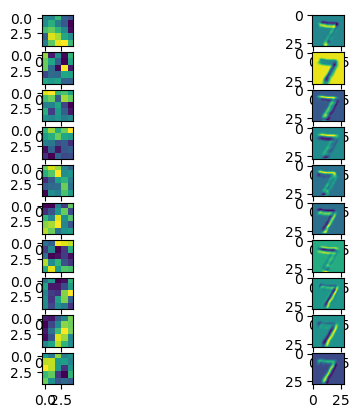

In [26]:
visualize()

In [27]:
i, x = next(enumerate(train_loader))
x[1][:5]

tensor([5, 0, 4, 1, 9])

In [28]:
y = network(x[0])
pred = y.data.max(1)[1]
pred[:5]

/var/folders/m9/f9b1skd55v35_qp4hcflk2qh0000gp/T/ipykernel_79719/161431047.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


tensor([5, 0, 4, 1, 9])

# How Much Data?

- What is the accuracy using 60,000 images? 30,000? 6,000? 3,000? 600?
- How do the weights looks different when trained with 60,000 vs 600?

In [29]:
# Set seed 
torch.manual_seed(42)

### 60,000 images

In [30]:
dataset1 = datasets.MNIST('data', train=True, download=True, transform=transform)
dataset1 = torch.utils.data.Subset(dataset1, range(60000))
train_loader = torch.utils.data.DataLoader(dataset1, batch_size=64)

In [31]:
# Create a new network and optimizer each time you try a new training set
network = Net()
optimizer = optim.SGD(network.parameters(), lr=0.01, momentum=0.5)
for epoch in range(5):
    train()
    test()

/var/folders/m9/f9b1skd55v35_qp4hcflk2qh0000gp/T/ipykernel_79719/161431047.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train loss: 2.326698
Train loss: 2.202992
Train loss: 1.548707
Train loss: 0.965259
Train loss: 0.733214
Train loss: 0.584287
Train loss: 0.587423
Train loss: 0.651645
Train loss: 0.575186
Train loss: 0.580905
Test accuracy: 93%

Train loss: 0.435604
Train loss: 0.491514
Train loss: 0.323234
Train loss: 0.561043
Train loss: 0.408683
Train loss: 0.410986
Train loss: 0.284992
Train loss: 0.387664
Train loss: 0.454853
Train loss: 0.421125
Test accuracy: 96%

Train loss: 0.293261
Train loss: 0.242441
Train loss: 0.330508
Train loss: 0.338163
Train loss: 0.201573
Train loss: 0.496916
Train loss: 0.158809
Train loss: 0.386033
Train loss: 0.235530
Train loss: 0.549762
Test accuracy: 97%

Train loss: 0.210935
Train loss: 0.105798
Train loss: 0.182116
Train loss: 0.314826
Train loss: 0.138307
Train loss: 0.234971
Train loss: 0.290094
Train loss: 0.340712
Train loss: 0.410363
Train loss: 0.488350
Test accuracy: 97%

Train loss: 0.176494
Train loss: 0.190522
Train loss: 0.157995
Train loss: 0.131

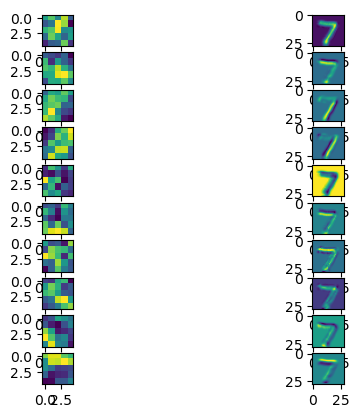

In [32]:
visualize()

### 30,000 images

In [33]:
dataset1 = datasets.MNIST('data', train=True, download=True, transform=transform)
dataset1 = torch.utils.data.Subset(dataset1, range(30000))
train_loader = torch.utils.data.DataLoader(dataset1, batch_size=64)

In [34]:
# Create a new network and optimizer each time you try a new training set
network = Net()
optimizer = optim.SGD(network.parameters(), lr=0.01, momentum=0.5)
for epoch in range(5):
    train()
    test()

/var/folders/m9/f9b1skd55v35_qp4hcflk2qh0000gp/T/ipykernel_79719/161431047.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train loss: 2.324687
Train loss: 1.741514
Train loss: 1.066642
Train loss: 0.713492
Train loss: 0.612382
Test accuracy: 92%

Train loss: 0.651417
Train loss: 0.393351
Train loss: 0.304230
Train loss: 0.481259
Train loss: 0.579608
Test accuracy: 95%

Train loss: 0.331348
Train loss: 0.380232
Train loss: 0.218719
Train loss: 0.535686
Train loss: 0.233754
Test accuracy: 96%

Train loss: 0.413175
Train loss: 0.385485
Train loss: 0.348863
Train loss: 0.494746
Train loss: 0.403591
Test accuracy: 97%

Train loss: 0.151079
Train loss: 0.247274
Train loss: 0.210605
Train loss: 0.495494
Train loss: 0.149599
Test accuracy: 97%



In [ ]:
visualize()

### 6,000 images

In [35]:
dataset1 = datasets.MNIST('data', train=True, download=True, transform=transform)
dataset1 = torch.utils.data.Subset(dataset1, range(6000))
train_loader = torch.utils.data.DataLoader(dataset1, batch_size=64)

In [36]:
# Create a new network and optimizer each time you try a new training set
network = Net()
optimizer = optim.SGD(network.parameters(), lr=0.01, momentum=0.5)
for epoch in range(5):
    train()
    test()

/var/folders/m9/f9b1skd55v35_qp4hcflk2qh0000gp/T/ipykernel_79719/161431047.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train loss: 2.299568
Test accuracy: 67%

Train loss: 1.980558
Test accuracy: 82%

Train loss: 1.210651
Test accuracy: 86%

Train loss: 0.945104
Test accuracy: 89%

Train loss: 0.690435
Test accuracy: 91%



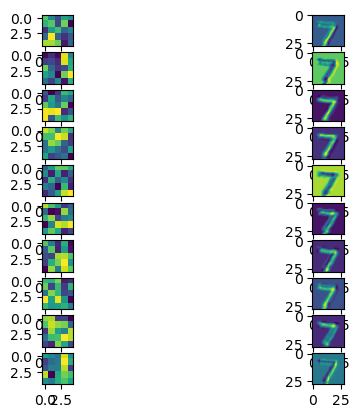

In [37]:
visualize()

### 3,000 images

In [38]:
dataset1 = datasets.MNIST('data', train=True, download=True, transform=transform)
dataset1 = torch.utils.data.Subset(dataset1, range(3000))
train_loader = torch.utils.data.DataLoader(dataset1, batch_size=64)

In [39]:
# Create a new network and optimizer each time you try a new training set
network = Net()
optimizer = optim.SGD(network.parameters(), lr=0.01, momentum=0.5)
for epoch in range(5):
    train()
    test()

/var/folders/m9/f9b1skd55v35_qp4hcflk2qh0000gp/T/ipykernel_79719/161431047.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train loss: 2.255797
Test accuracy: 39%

Train loss: 2.215378
Test accuracy: 51%

Train loss: 2.165917
Test accuracy: 66%

Train loss: 1.884933
Test accuracy: 81%

Train loss: 1.127427
Test accuracy: 86%



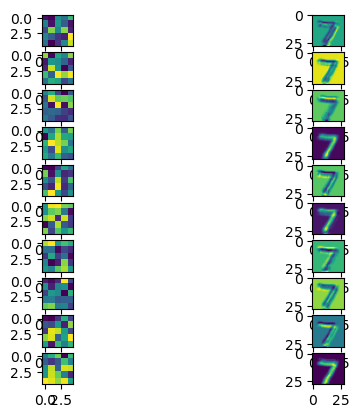

In [40]:
visualize()

### 600 images

In [41]:
dataset1 = datasets.MNIST('data', train=True, download=True, transform=transform)
dataset1 = torch.utils.data.Subset(dataset1, range(600))
train_loader = torch.utils.data.DataLoader(dataset1, batch_size=64)

In [42]:
# Create a new network and optimizer each time you try a new training set
network = Net()
optimizer = optim.SGD(network.parameters(), lr=0.01, momentum=0.5)
for epoch in range(5):
    train()
    test()

/var/folders/m9/f9b1skd55v35_qp4hcflk2qh0000gp/T/ipykernel_79719/161431047.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train loss: 2.304117
Test accuracy: 13%

Train loss: 2.264367
Test accuracy: 16%

Train loss: 2.230297
Test accuracy: 30%

Train loss: 2.243992
Test accuracy: 39%

Train loss: 2.175119
Test accuracy: 42%



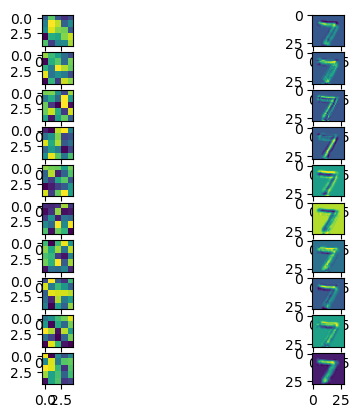

In [43]:
visualize()

### 1a
Accuracies
60,000 - 98%
30,000 - 97%
6,000 - 91% 
3,000 - 86%
600 - 42%


### 1b
There is more distinct coloring and grading in 60,000 set compared to 600 set.